In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random

In [14]:
class zNode:
    def __init__(self,layerNo,value,absVal,pos):
      self.layerNo = layerNo
      self.value = value
      self.absVal = absVal
      self.pos = pos


class madaline:
  #N_layers, Layer_sizes, activation, learning_rate, weight_init, batch_size, num_epochs

  def __init__(self,N_layers, Layer_sizes, learning_rate, weight_init, num_epochs,threshold):
    self.N_layers = N_layers
    self.Layer_sizes = Layer_sizes #includes input layer, hidden layers as well as output layer
    self.learning_rate = learning_rate
    self.weight_init = weight_init
    self.num_epochs = num_epochs
    self.threshold = threshold

  def zero_weight_init(self):
    w = []
    for l in range(1,self.N_layers):
      w.append(np.zeros((self.Layer_sizes[l],self.Layer_sizes[l-1])))
    return w

  def random_weight_init(self):
    w = []
    for l in range(1,self.N_layers):
      w.append(np.random.rand(self.Layer_sizes[l],self.Layer_sizes[l-1]))

    return w


  def normal_weight_init(self):
    w = []
    for l in range(1,self.N_layers):
      w.append(np.random.normal(0,1,(self.Layer_sizes[l],self.Layer_sizes[l-1]))*0.01)

    return w

  def initialize(self):
    if(self.weight_init == "zero"):
      weight = self.zero_weight_init()
    elif(self.weight_init == "random"):
      weight = self.random_weight_init()
    if(self.weight_init == "normal"):
      weight = self.normal_weight_init()

    l = self.Layer_sizes
    n = self.N_layers
    bias = []
    for i in range(n-1):
      bias.append(np.random.normal(0,1,(l[i+1])))

    return weight,bias 


  def forward_calcV(self,y_l1,weight_l,bias):
    v_l = np.dot(y_l1,weight_l.T) + bias
    return v_l

  def forward_propagation(self,x,weight,bias,startLayer):
    z = {}
    y = []
    
    y.append(x)
    y_l1 = x

    if(startLayer==self.N_layers):
      y_l1[y_l1>=self.threshold] = 1
      y_l1[y_l1<self.threshold] = 0

    for l in range(startLayer,self.N_layers):
      
      z_l = self.forward_calcV(y_l1,weight[l-1],bias[l-1])
      
      Ztemp = []
      for i in range(0,len(z_l)):
        ZN = zNode(l,z_l[i],abs(z_l[i]),i)
        Ztemp.append(ZN)

      z[l] = Ztemp

      y_l1 = z_l
      y_l1[y_l1>=self.threshold] = 1
      y_l1[y_l1<self.threshold] = 0
      
      y.append(y_l1)
      
    yOutput = y_l1[0]
 
    return yOutput,z,y

  def checkConvergence(self,x,d,weight,bias):
    yPredict = self.predict(x,weight,bias)
    if(self.error(d,yPredict)<=0):
      return True
    return False

  def fit(self,x,d,):
    weight,bias = self.initialize()
   
    j = 0
    misClass = np.zeros(self.num_epochs)
    ep = np.zeros(self.num_epochs)

    while (j<self.num_epochs and self.checkConvergence(x,d,weight,bias)==False):
      print(j)
      
      for i in range(0,len(x)):
        yOutput,z,y = self.forward_propagation(x[i],weight,bias,1)
        
        if d[i]!=yOutput:
          l = 1
          flag = 0
          while (l<self.N_layers):
            zl = z[l]
            while(len(zl)>0):

          # while untestedNeurons>0:
            #find untested neuron n with smallest z, z closest to 0
             
              zMin = min(zl, key=lambda zl: zl.absVal)
              zl.remove(zMin)
            
              #flip the output of yn
              y[zMin.layerNo][zMin.pos] = 1-y[zMin.layerNo][zMin.pos]

              #re-evaluate the network with the output of n flipped to obtain new final output
              yOutput,znn,ynn = self.forward_propagation(y[zMin.layerNo],weight,bias,zMin.layerNo+1)

              #if flipping the neuron has corrected the final output then
              if yOutput == d[i]:
                #Update weight of neuron n
                weight[zMin.layerNo-1][zMin.pos] = weight[zMin.layerNo-1][zMin.pos] + self.learning_rate * (y[zMin.layerNo][zMin.pos] - zMin.value)*y[zMin.layerNo-1]
                bias[zMin.layerNo-1][zMin.pos] = bias[zMin.layerNo-1][zMin.pos] + self.learning_rate * (y[zMin.layerNo][zMin.pos] - zMin.value)
                flag = 1
                break
              else:
                #reverse the flipped neuron
                y[zMin.layerNo][zMin.pos] = 1-y[zMin.layerNo][zMin.pos]

            l = l+1
            if flag==1:
              break

      ep[j] = j
      y = self.predict(x,weight,bias)
      err = self.error(d,y)
      misClass[j] = err
      j = j+1

    return weight,bias,misClass,ep


  def predict(self,x,weight,bias):
    yPredict = []
    for i in range(0,len(x)):
      yOutput,z,y = self.forward_propagation(x[i],weight,bias,1)
      yPredict.append(yOutput)
    return yPredict

  def error(self,d,y):
    y = np.array(y)
    err = sum(d!=y)
    return err

  def Mse(self,d,y):
    y = np.array(y)
    mse = 0.5 * np.square(d - y).mean()
    # print(mse)
    return mse

  def saveModel(self,weight,bias):
    modelSave = {'weight': weight, 'bias': bias, 'Layer_size':self.Layer_sizes, 'N_layer':self.N_layers, 'learning_rate':self.learning_rate, 'weight_init':self.weight_init,'num_epochs':self.num_epochs,'threshold':self.threshold }
    with open('fileModel.pkl', 'wb') as file:
      pickle.dump(modelSave, file)

  def accuracy(self,X,d,y):
    y = np.array(y)
    missed = sum(d!=y)
    acc = ((X.shape[0] - missed)/(X.shape[0]))*100
    return acc



    

In [15]:
def createDataset():
  X = []
  d = []
  for x in range(0,11):
    for y in range(0,11):
      X.append([x,y])
      if(x>=4 and x<=6 and ((y>=0 and y<=2) or (y>=4 and y<=6) or (y>=8 and y<=10))):
        d.append(1)
      elif(y>=4 and y<=6 and ((x>=0 and x<=2) or (x>=8 or x<=10))):
        d.append(1)
      else:
        d.append(0) 

  print('X: ',X)
  print('d: ' ,d)
  X = np.array(X)
  d = np.array(d)
  return X,d


In [20]:
def loadModel(filename):
    with open(filename, 'rb') as f:
      modelSave = pickle.load(f)

    return modelSave

X:  [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [3, 0], [3, 1], [3, 2], [3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [4, 0], [4, 1], [4, 2], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [5, 0], [5, 1], [5, 2], [5, 3], [5, 4], [5, 5], [5, 6], [5, 7], [5, 8], [5, 9], [5, 10], [6, 0], [6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7], [6, 8], [6, 9], [6, 10], [7, 0], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 7], [7, 8], [7, 9], [7, 10], [8, 0], [8, 1], [8, 2], [8, 3], [8, 4], [8, 5], [8, 6], [8, 7], [8, 8], [8, 9], [8, 10], [9, 0], [9, 1], [9, 2], [9, 3], [9, 4], [9, 5], [9, 6], [9, 7], [9, 8], [9, 9], [9, 10], [10, 0], [10, 1], [10, 2], [10, 3], [10, 4], [10, 5], [10, 6], [10, 7], [10, 8], [10, 9], [10, 10]]
d:  [

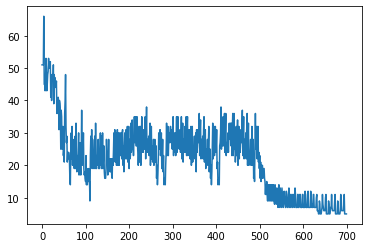

In [22]:
X,d = createDataset()
np.random.seed(823)
model = madaline(4,[2,12,5,1],0.001,"normal",700,0)
w,b,misClass,ep = model.fit(X,d)
y = model.predict(X,w,b)
print('Predicted: ',y)
err = model.error(d,y)
print('Misclassified samples: ',err)
acc = model.accuracy(X,d,y)
print('Accuracy: ',acc)
plt.plot(ep, misClass)



In [18]:
model.saveModel(w,b)

In [21]:
X,d = createDataset()
modelSave = loadModel('fileModel.pkl')
model = madaline(modelSave['N_layer'],modelSave['Layer_size'],modelSave['learning_rate'],"normal",modelSave['num_epochs'],modelSave['threshold'])
y = model.predict(X,modelSave['weight'],modelSave['bias'])
print('Predicted: ',y)
err = model.error(d,y)
print('Misclassfied samples: ',err)
acc = model.accuracy(X,d,y)
print('Accuracy: ',acc)


X:  [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [3, 0], [3, 1], [3, 2], [3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [4, 0], [4, 1], [4, 2], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [5, 0], [5, 1], [5, 2], [5, 3], [5, 4], [5, 5], [5, 6], [5, 7], [5, 8], [5, 9], [5, 10], [6, 0], [6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7], [6, 8], [6, 9], [6, 10], [7, 0], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 7], [7, 8], [7, 9], [7, 10], [8, 0], [8, 1], [8, 2], [8, 3], [8, 4], [8, 5], [8, 6], [8, 7], [8, 8], [8, 9], [8, 10], [9, 0], [9, 1], [9, 2], [9, 3], [9, 4], [9, 5], [9, 6], [9, 7], [9, 8], [9, 9], [9, 10], [10, 0], [10, 1], [10, 2], [10, 3], [10, 4], [10, 5], [10, 6], [10, 7], [10, 8], [10, 9], [10, 10]]
d:  [